In [362]:
# Source: https://data.world/jonloyens/inside-airbnb-austin
# dataset created on 2016-07-15

In [363]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [364]:
# import nltk
# nltk.download('vader_lexicon')

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import dataframe_image as dfi
from collections import Counter

In [3]:
#importing all the data

# calendar = pd.read_csv('C:\\Users\\Richard\\Desktop\\data_airbnb\\calendar.csv')
# listings = pd.read_csv('C:\\Users\\Richard\\Desktop\\data_airbnb\\listings.csv')
# listings_summary = pd.read_csv('C:\\Users\\Richard\\Desktop\\data_airbnb\\listings_summary.csv')
# reviews = pd.read_csv('C:\\Users\\Richard\\Desktop\\data_airbnb\\reviews.csv')
# # neighbourhoods = pd.read_csv('C:\\Users\\Richard\\Desktop\\data_airbnb\\neighbourhoods.csv')
# # neighbourhoods_2 = pd.read_csv('C:\\Users\\Richard\\Desktop\\data_airbnb\\neighbourhoods_2.csv')
# # reviews_summary = pd.read_csv('C:\\Users\\Richard\\Desktop\\data_airbnb\\reviews_summary.csv')

calendar = pd.read_csv('./data/calendar.csv')
listings = pd.read_csv('./data/listings.csv')
listings_summary = pd.read_csv('./data/listings_summary.csv')
reviews = pd.read_csv('./data/reviews.csv')

In [4]:
calendar['listing_id'] = calendar.listing_id.astype(str)
calendar['date'] = pd.to_datetime(calendar.date)

In [5]:
c = Counter(listings.dtypes.values)
print(c)

Counter({dtype('O'): 45, dtype('float64'): 28, dtype('int64'): 14, dtype('bool'): 6})


In [6]:
listings['id'] = listings.id.astype(int)
listings['thumbnail_exists'] = listings.thumbnail_url.isna().apply(lambda x: int(not x))
listings['medium_exists'] = listings.medium_url.isna().apply(lambda x: int(not x))
listings['picture_exists'] = listings.picture_url.isna().apply(lambda x: int(not x))
listings['xl_picture_exists'] = listings.xl_picture_url.isna().apply(lambda x: int(not x))
listings['last_scraped'] = pd.to_datetime(listings.last_scraped)
listings['host_name'] = listings.host_name.astype(str)
listings['host_since'] = pd.to_datetime(listings.host_since)
listings['host_is_superhost'] = listings.host_is_superhost.astype(bool).astype(int)
def host_response_time_cleaning(arg):
    return {np.nan: np.nan, 'within an hour': 0, 'within a few hours': 1, 'within a day': 2, 'a few days or more': 3}[arg]
listings['host_response_time_numeric'] = listings.host_response_time.apply(host_response_time_cleaning)
listings['host_response_time_numeric'].fillna(listings.host_response_time_numeric.mean(), inplace = True)
l = list(map(lambda x: eval(x), listings.host_verifications))
host_verifications_master_list = []
for ll in l:
    try:
        for i in ll:
            if i not in host_verifications_master_list:
                host_verifications_master_list.append(i)
    except TypeError:
        None
# print(host_verifications_master_list)
for verification_method in host_verifications_master_list:
    listings['host_verification_'+verification_method] = listings.host_verifications.apply(lambda x: int(verification_method in x))
listings['host_has_profile_pic'] = listings.host_has_profile_pic.astype(bool).astype(int)
listings['host_identity_verified'] = listings.host_identity_verified.astype(bool).astype(int)
#FillNA with 1. If this is NA, assume the worst: assume that this host does not have any other listings besides
#the said listing: thus total listings count being 1.
listings['host_total_listings_count'].fillna(1, inplace = True)
listings['host_total_listings_count'] = listings.host_total_listings_count.astype(int)
listings['calendar_last_scraped'] = pd.to_datetime(listings.calendar_last_scraped)
listings['first_review'] = pd.to_datetime(listings.first_review)
listings['last_review'] = pd.to_datetime(listings.last_review)
def cancellation_policy_cleaning(arg):
    return {'flexible': 0,
           'moderate': 1,
           'strict': 2,
           'super_strict_30': 3,
           'no_refunds': 4}[arg]
listings['cancellation_policy_numeric'] = listings.cancellation_policy.apply(cancellation_policy_cleaning)
#There are too many different categorical type of bed types, but the overwhelming majority is the "Real Bed"
#To avoid curse of dimensionality, make it a boolean of whether if it's a Real Bed or not. 
listings['is_real_bed'] = listings.bed_type.apply(lambda x: int(x == 'Real Bed'))
listings['host_response_rate'].fillna(listings.host_response_rate.mean(), inplace = True)
listings['host_acceptance_rate'].fillna(listings.host_acceptance_rate.mean(), inplace = True)

def property_type_cleaning(arg):
    if arg not in ['House', 'Apartment']:
        return 'other'
    else:
        return arg
listings['property_type_cleaned'] = listings.property_type.apply(property_type_cleaning)
listings['requires_license'] = listings.requires_license.astype(int)
listings['instant_bookable'] = listings.instant_bookable.astype(int)
listings['require_guest_profile_picture'] = listings.require_guest_profile_picture.astype(int)
listings['require_guest_phone_verification'] = listings.require_guest_phone_verification.astype(int)

basedate = pd.Timestamp('2016-07-15')
listings['days_since_hosting'] = listings.host_since.apply(lambda x: (basedate - x).days)
listings['days_since_last_updated'] = listings.last_scraped.apply(lambda x: (basedate - x).days)

# Fill NA values with 0s. As they pertain to review scores for a review that does not exist, filling NA's with
# the zeroes. This overexaggerates the ones with reviews, which will be beneficial to the modeling. 
listings['reviews_per_month'].fillna(0, inplace = True)
listings['review_scores_rating'].fillna(0, inplace = True)
listings['review_scores_accuracy'].fillna(0, inplace = True)
listings['review_scores_cleanliness'].fillna(0, inplace = True)
listings['review_scores_checkin'].fillna(0, inplace = True)
listings['review_scores_communication'].fillna(0, inplace = True)
listings['review_scores_value'].fillna(0, inplace = True)

#filling NA values with 0s, as these pertain to special house structures that don't have regular 'counts'
#of a normal housing feature
listings['bathrooms'].fillna(0, inplace = True)
listings['bedrooms'].fillna(0, inplace = True)
listings['beds'].fillna(0, inplace = True)

#missing information on how long the account has been active for. Assume the worst and fillNA with 1 day old account.
listings['days_since_hosting'].fillna(1, inplace = True)

listings['square_feet'].fillna(listings.square_feet.mean(), inplace = True)

#number of days that the listing was 'sold out' in 2015.
days_sold_per_listing = calendar.loc[~calendar.available].groupby('listing_id').count()[['available']].reset_index()
days_sold_per_listing.listing_id = days_sold_per_listing.listing_id.astype(int)

listings = listings.merge(days_sold_per_listing, how = 'left', left_on = 'id', right_on = 'listing_id')
listings['available'].fillna(listings.available.mean(), inplace = True)


In [7]:
listings_abbr = listings[['id', 'host_id', 'host_response_rate', 
          'host_acceptance_rate', 'host_is_superhost', 'host_total_listings_count',
          'host_has_profile_pic', 'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights',
          'maximum_nights','availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
          'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_value',
          'requires_license', 'instant_bookable', 'require_guest_profile_picture',
          'require_guest_phone_verification', 'calculated_host_listings_count', 'reviews_per_month',
          'thumbnail_exists', 'medium_exists', 'picture_exists', 'xl_picture_exists', 'host_response_time_numeric', 
          'host_verification_email', 'host_verification_facebook', 'host_verification_linkedin', 
          'host_verification_reviews', 
          'host_verification_phone', 'host_verification_google', 'host_verification_kba', 
          'host_verification_jumio', 'host_verification_sent_id', 'host_verification_manual_online', 
          'host_verification_manual_offline', 'host_verification_photographer', 'host_verification_amex', 
          'cancellation_policy_numeric', 'is_real_bed', 'days_since_hosting', 'days_since_last_updated',
          'square_feet', 'available']]

In [8]:
#doing One-hot Encoding for all categorical values

listings_property_type_OHE = pd.get_dummies(listings.property_type_cleaned)
listings_room_type_OHE = pd.get_dummies(listings.room_type)
listings2 = pd.concat([listings_abbr, listings_property_type_OHE, listings_room_type_OHE], axis = 1)

In [9]:
sia = SentimentIntensityAnalyzer()

reviews['date'] = pd.to_datetime(reviews.date)
def comments_sentiment_neg_cleaning(arg):
    try:
        return sia.polarity_scores(arg)['neg']
    except:
        return -1
def comments_sentiment_neu_cleaning(arg):
    try:
        return sia.polarity_scores(arg)['neu']
    except:
        return -1
def comments_sentiment_pos_cleaning(arg):
    try:
        return sia.polarity_scores(arg)['pos']
    except:
        return -1
def comments_sentiment_com_cleaning(arg):
    try:
        return sia.polarity_scores(arg)['compound']
    except:
        return -1

reviews['comments_sentiment_neg'] = reviews.comments.apply(comments_sentiment_neg_cleaning)
reviews['comments_sentiment_neu'] = reviews.comments.apply(comments_sentiment_neu_cleaning)
reviews['comments_sentiment_pos'] = reviews.comments.apply(comments_sentiment_pos_cleaning)
reviews['comments_sentiment_com'] = reviews.comments.apply(comments_sentiment_com_cleaning)

In [10]:
# dropping 11 out of 62371 rows where Sentiment Intensity Analyzer Fails
reviews2 = reviews.loc[(reviews.comments_sentiment_neg != -1) & \
           (reviews.comments_sentiment_neu != -1) & \
           (reviews.comments_sentiment_pos != -1) & \
           (reviews.comments_sentiment_com != -1)]

In [374]:
reviews2.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,comments_sentiment_neg,comments_sentiment_neu,comments_sentiment_pos,comments_sentiment_com
0,2390109,22208895,2014-11-01,4358294,Inessa,I had a great time staying here! The room is h...,0.000,0.792,0.208,0.9637
1,2390109,22619785,2014-11-10,12361335,Colibri,What a wonderful space in a beautiful & quiet ...,0.000,0.730,0.270,0.9595
2,2390109,23234873,2014-11-25,6359216,Giuseppe,The reservation was canceled 107 days before a...,0.000,1.000,0.000,0.0000
3,2390109,23338508,2014-11-29,23638127,Sophia,When I saw the posting and how clean and simpl...,0.017,0.815,0.168,0.9870
4,2390109,24989361,2015-01-04,3088100,Taylor,This is one of the first times we've been hesi...,0.021,0.794,0.186,0.9914


In [11]:
avg_review_per_listing = reviews2[['listing_id', 
                                   'comments_sentiment_neg', 
                                   'comments_sentiment_neu', 
                                   'comments_sentiment_pos',
                                   'comments_sentiment_com']]\
.groupby('listing_id').mean()

In [12]:
avg_review_per_listing.reset_index().head()

,listing_id,comments_sentiment_neg,comments_sentiment_neu,comments_sentiment_pos,comments_sentiment_com
0,1078,0.008343,0.690147,0.301510,0.901355
1,2265,0.026250,0.714333,0.259333,0.763533
2,5245,0.002500,0.648000,0.349500,0.937433
3,5456,0.011952,0.679112,0.308917,0.896716
4,5769,0.010700,0.642911,0.346383,0.908331


In [13]:
listings3 = listings2.merge(avg_review_per_listing.reset_index(), left_on = 'id', right_on = 'listing_id', how = 'left')
listings3.drop(columns = ['listing_id'], inplace = True)

In [14]:
listings3.head()

,id,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,thumbnail_exists,medium_exists,picture_exists,xl_picture_exists,host_response_time_numeric,host_verification_email,host_verification_facebook,host_verification_linkedin,host_verification_reviews,host_verification_phone,host_verification_google,host_verification_kba,host_verification_jumio,host_verification_sent_id,host_verification_manual_online,host_verification_manual_offline,host_verification_photographer,host_verification_amex,cancellation_policy_numeric,is_real_bed,days_since_hosting,days_since_last_updated,square_feet,available,Apartment,House,other,Entire home/apt,Private room,Shared room,comments_sentiment_neg,comments_sentiment_neu,comments_sentiment_pos,comments_sentiment_com
0,72635,377044,0.934972,0.861244,0,1,1,0,6,2.5,1.0,3.0,300.0,2,10,240,1,100.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,1,0.02,1,1,1,1,0.756045,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1988.0,250,3600.000000,125.000000,0,1,0,0,1,0,0.0,0.705,0.295,0.9441
1,5386323,27922117,0.934972,0.861244,0,1,1,1,2,0.0,1.0,1.0,99.0,3,7,364,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0.00,1,1,1,1,0.756045,1,0,0,0,1,1,1,0,0,0,0,0,0,1,0,514.0,251,1309.596026,1.000000,0,0,1,0,1,0,NaN,NaN,NaN,NaN
2,8826517,46230038,0.934972,0.861244,0,2,1,1,2,1.5,1.0,1.0,100.0,1,1125,365,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,2,0.00,1,1,1,1,0.756045,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,279.0,251,1309.596026,120.863231,0,1,0,0,1,0,NaN,NaN,NaN,NaN
3,8828616,46230038,0.934972,0.861244,0,2,1,1,2,1.5,1.0,1.0,100.0,1,1125,365,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,2,0.00,1,1,1,1,0.756045,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,279.0,250,1309.596026,120.863231,0,1,0,0,1,0,NaN,NaN,NaN,NaN
4,8536913,31148752,0.980000,0.810000,0,301,1,1,6,2.0,3.0,3.0,599.0,2,1125,358,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,2,0.00,1,1,1,1,1.000000,1,0,1,1,1,0,0,1,0,0,0,0,0,2,1,459.0,250,1309.596026,7.000000,0,1,0,1,0,0,NaN,NaN,NaN,NaN


In [15]:
listings3['comments_sentiment_neg'].fillna(listings3.comments_sentiment_neg.mean(), inplace = True)
listings3['comments_sentiment_neu'].fillna(listings3.comments_sentiment_neu.mean(), inplace = True)
listings3['comments_sentiment_pos'].fillna(listings3.comments_sentiment_pos.mean(), inplace = True)
listings3['comments_sentiment_com'].fillna(listings3.comments_sentiment_com.mean(), inplace = True)

In [16]:
listings3.columns

Index(['id', 'host_id', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_value',
       'requires_license', 'instant_bookable', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month', 'thumbnail_exists', 'medium_exists',
       'picture_exists', 'xl_picture_exists', 'host_response_time_numeric',
       'host_verification_email', 'host_verification_facebook',
       'host_verification_linkedin', 'host_verification_reviews',
       'host_verification_phone', 'host_verification_google'

In [17]:
cols = ['host_response_rate'
    , 'host_acceptance_rate'
    , 'host_is_superhost'
    , 'host_total_listings_count'
    , 'host_has_profile_pic'
    , 'host_identity_verified'
    , 'accommodates'
    , 'bathrooms'
    , 'bedrooms'
    , 'beds'
    , 'minimum_nights' 
    , 'maximum_nights'
    , 'availability_365'
    , 'number_of_reviews'
    , 'review_scores_rating'
    , 'review_scores_accuracy'
    , 'review_scores_cleanliness'
    , 'review_scores_checkin'
    , 'review_scores_communication'
    , 'review_scores_value'
    , 'instant_bookable'
    , 'require_guest_profile_picture'
    , 'require_guest_phone_verification'
    , 'calculated_host_listings_count'
    , 'reviews_per_month'
    , 'thumbnail_exists'
    , 'medium_exists'
    , 'xl_picture_exists'
    , 'host_response_time_numeric'
    , 'host_verification_email'
    , 'host_verification_facebook'
    , 'host_verification_linkedin'
    , 'host_verification_reviews'
    , 'host_verification_phone'
    , 'host_verification_google'
    , 'host_verification_kba'
    , 'host_verification_jumio'
    , 'host_verification_sent_id'
    , 'host_verification_manual_online'
    , 'host_verification_manual_offline'
    , 'host_verification_photographer'
    , 'host_verification_amex'
    , 'cancellation_policy_numeric'
    , 'is_real_bed'
    , 'days_since_hosting'
    , 'days_since_last_updated'
    , 'Apartment'
    , 'House'
    , 'other'
    , 'Entire home/apt'
    , 'Private room'
    , 'Shared room'
    , 'comments_sentiment_neg'
    , 'comments_sentiment_neu'
    , 'comments_sentiment_pos'
    , 'comments_sentiment_com'
    , 'square_feet'
    , 'available'
       ]

In [18]:
X = listings3.loc[:, cols]
y = listings3.price
reg = LinearRegression().fit(X, y)

In [19]:
reg.coef_

array([ 3.02696134e+01,  6.08866957e+01, -1.60995683e+01, -4.53997201e-02,
        1.62998850e+01, -2.11752501e+01,  6.11122715e+00,  1.98762808e+02,
        6.03576929e+01,  1.98146980e+00, -9.04698125e-01, -1.35927833e-02,
        7.78532497e-01, -1.58307635e-02,  1.96250535e+00, -6.31254775e+00,
        2.60417189e+00, -1.49389820e+00, -5.16656336e+00, -1.82705033e+01,
       -1.06177152e+01, -1.09891896e+02,  4.72832492e+01, -3.50719934e+00,
       -3.21649299e+00, -5.17238615e-01, -5.17238615e-01, -5.17238615e-01,
        3.57116935e+00, -1.04562504e+01, -1.53524455e+01,  8.06748563e+00,
       -6.41096223e+01,  2.42889190e+01, -2.54918712e+01,  1.93721398e+01,
        1.89565217e+01, -1.85352912e+01,  7.88326429e+01, -4.63070356e+01,
        3.23493100e+01, -1.74199727e+02,  1.52785303e+01,  9.16070754e+00,
        5.13265568e-03,  1.47181518e+00,  1.14368128e+01, -8.96020033e+00,
       -2.47661248e+00,  5.73508429e+01, -1.34505054e+01, -4.39003376e+01,
       -5.04834787e+03, -

In [20]:
reg.intercept_

4495.291302805727

In [21]:
reg.score(X,y) #R^2 value

0.4275678275613439

In [22]:
d = dict(zip(cols, reg.coef_))

In [23]:
d

{'host_response_rate': 30.269613376326223,
 'host_acceptance_rate': 60.88669572008533,
 'host_is_superhost': -16.099568263196815,
 'host_total_listings_count': -0.04539972013336788,
 'host_has_profile_pic': 16.299884995442902,
 'host_identity_verified': -21.175250073541957,
 'accommodates': 6.111227154886083,
 'bathrooms': 198.76280807441108,
 'bedrooms': 60.35769287552635,
 'beds': 1.9814698025915587,
 'minimum_nights': -0.9046981247415269,
 'maximum_nights': -0.01359278325335822,
 'availability_365': 0.7785324971612653,
 'number_of_reviews': -0.015830763451383234,
 'review_scores_rating': 1.9625053543730928,
 'review_scores_accuracy': -6.312547749945489,
 'review_scores_cleanliness': 2.604171886455748,
 'review_scores_checkin': -1.4938981972038725,
 'review_scores_communication': -5.16656336109898,
 'review_scores_value': -18.27050330126645,
 'instant_bookable': -10.617715159739015,
 'require_guest_profile_picture': -109.89189638863849,
 'require_guest_phone_verification': 47.2832492

In [24]:
X_ = sm.add_constant(X)
est = sm.OLS(y, X_)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     79.95
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:35:07   Log-Likelihood:                -41659.
No. Observations:                5835   AIC:                         8.343e+04
Df Residuals:                    5780   BIC:                         8.379e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [25]:
corr = X.corr()
correlation_matrix_1 = corr.style.background_gradient(cmap='coolwarm')
correlation_matrix_1
# dfi.export(correlation_matrix_1,"correlation_matrix_1.png", max_cols = -1)

,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,thumbnail_exists,medium_exists,xl_picture_exists,host_response_time_numeric,host_verification_email,host_verification_facebook,host_verification_linkedin,host_verification_reviews,host_verification_phone,host_verification_google,host_verification_kba,host_verification_jumio,host_verification_sent_id,host_verification_manual_online,host_verification_manual_offline,host_verification_photographer,host_verification_amex,cancellation_policy_numeric,is_real_bed,days_since_hosting,days_since_last_updated,Apartment,House,other,Entire home/apt,Private room,Shared room,comments_sentiment_neg,comments_sentiment_neu,comments_sentiment_pos,comments_sentiment_com,square_feet,available
host_response_rate,1.000000,0.050902,0.156052,0.087204,-0.008140,0.053519,0.015898,0.016265,0.018376,0.017311,0.000178,-0.041848,-0.039462,0.066325,0.068690,0.070658,0.076019,0.067663,0.067856,0.066280,0.077829,-0.004563,-0.005226,-0.006061,0.097754,0.000300,0.000300,0.000300,-0.549391,0.060306,-0.007484,0.035623,0.049775,-0.002559,0.052215,0.069441,-0.034533,0.013906,0.029380,-0.004044,0.000000,0.006189,0.073411,0.028378,0.031968,-0.003401,-0.056724,0.061675,-0.014121,0.016440,-0.004449,-0.038699,-0.026113,-0.031728,0.035591,0.070065,0.002219,0.011695
host_acceptance_rate,0.050902,1.000000,0.099189,0.001713,-0.011211,0.021600,-0.041484,-0.045801,-0.059507,-0.034711,0.000809,-0.025012,-0.033641,0.122857,0.074492,0.072274,0.076693,0.074216,0.074751,0.077528,0.158310,0.011056,0.010381,0.010843,0.198285,0.042171,0.042171,0.042171,-0.213428,-0.002674,-0.008683,-0.001355,0.041598,-0.003524,0.032892,0.031065,-0.016030,-0.019985,-0.012738,-0.012681,0.000000,0.003624,-0.001929,-0.007161,-0.037292,-0.009534,0.033250,-0.041478,0.018228,-0.022446,0.023076,-0.000486,-0.009891,-0.042370,0.043069,0.011312,-0.020209,0.002798
host_is_superhost,0.156052,0.099189,1.000000,-0.058010,0.019418,0.165409,0.002496,-0.028957,-0.028386,0.026937,0.027251,-0.039165,0.027124,0.353371,0.241187,0.242298,0.247590,0.235490,0.235415,0.246487,0.051947,0.134751,0.143162,0.102862,0.298186,0.027524,0.027524,0.027524,-0.171874,0.061496,0.067018,0.094331,0.190657,-0.066515,0.057979,0.117039,0.022212,0.067505,0.032750,0.017404,-0.005380,0.033688,0.182605,0.024488,0.160558,-0.004695,-0.119336,0.112973,0.001636,-0.023904,0.031737,-0.022974,-0.027002,-0.050879,0.054621,0.130374,-0.050757,-0.096058
host_total_listings_count,0.087204,0.001713,-0.058010,1.000000,0.009213,0.128039,0.176678,0.165442,0.163469,0.154350,0.009817,-0.053782,0.042510,-0.026373,0.051276,0.057972,0.060539,0.055022,0.052558,0.053120,-0.052069,-0.028179,-0.034459,0.345133,-0.043057,-0.004251,-0.004251,-0.004251,0.056187,0.044865,-0.168377,0.036747,0.097972,0.014703,0.272997,0.120926,-0.010688,-0.007101,-0.011788,-0.019054,-0.002552,-0.003461,0.199487,0.032528,0.030955,0.030882,-0.066100,0.083935,-0.038997,0.111326,-0.105980,-0.024169,0.044597,0.061397,-0.067859,-0.154287,0.012393,-0.087944
host_has_profile_pic,-0.008140,-0.011211,0.019418,0.009213,1.000000,0.037066,0.018989,0.018968,0.011441,0.019009,-0.002393,0.003325,-0.002656,0.013068,0.025622,0.032949,0.024534,0.026001,0.025259,0.024939,0.014827,0.010728,-0.001565,0.018657,0.012506,0.005779,0.005779,0.005779,0.015822,0.053050,0.025194,0.003091,0.048007,0.141851,0.022264,0.026523,0.012592,0.002973,0.003100,0.005207,0.000619,0.001072,0.014231,-0.008948,0.013648,0.003222,-0.037992,0.029111,0.013328,-0.007542,0.013559,-0.018370,-0.018594,0.012269,-0.008770,0.001079,-0.000000,-0.006142
host_iden

In [26]:
cols2 = '''


host_acceptance_rate
host_is_superhost
accommodates
bathrooms
bedrooms
maximum_nights
availability_365
require_guest_profile_picture
calculated_host_listings_count
host_verification_facebook
host_verification_reviews
host_verification_google
cancellation_policy_numeric
square_feet
comments_sentiment_com
available



'''.strip().split('\n')

In [27]:
X2 = listings3.loc[:, cols2]
X2_ = sm.add_constant(X2)
est = sm.OLS(y, X2_)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     255.3
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:35:07   Log-Likelihood:                -41735.
No. Observations:                5835   AIC:                         8.350e+04
Df Residuals:                    5818   BIC:                         8.362e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [28]:
est2.params

const                            -515.815442
host_acceptance_rate               46.426638
host_is_superhost                 -35.629781
accommodates                       11.441109
bathrooms                         199.811897
bedrooms                           64.711433
maximum_nights                     -0.010458
availability_365                    0.809784
require_guest_profile_picture     -73.356847
calculated_host_listings_count     -3.860094
host_verification_facebook        -13.957755
host_verification_reviews        -131.494932
host_verification_google          -31.684756
cancellation_policy_numeric        17.463620
square_feet                         0.039435
comments_sentiment_com             59.289508
available                           0.889841
dtype: float64

In [29]:
corr2 = X2.corr()
correlation_matrix_2 = corr2.style.background_gradient(cmap='coolwarm')
dfi.export(correlation_matrix_2,"correlation_matrix_2.png", max_cols = -1)

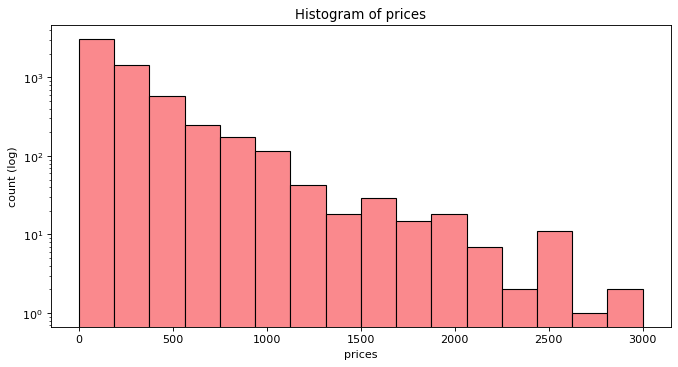

In [293]:
plt.figure(figsize=(10, 5), dpi = 80)

plt.hist(x = y, bins = 16, range = (0, 3000), log = True, color = '#fa898d', edgecolor = 'black')

plt.xlabel('prices')
plt.ylabel('count (log)')
plt.title('Histogram of prices')

plt.show()

In [295]:
X.availability_365.head()

0    240
1    364
2    365
3    365
4    358
Name: availability_365, dtype: int64

In [313]:
X.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'minimum_nights', 'maximum_nights', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_value',
       'instant_bookable', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month', 'thumbnail_exists', 'medium_exists',
       'xl_picture_exists', 'host_response_time_numeric',
       'host_verification_email', 'host_verification_facebook',
       'host_verification_linkedin', 'host_verification_reviews',
       'host_verification_phone', 'host_verification_google',
       'host_verification_kba', 'host_verification_jumio',
       'ho

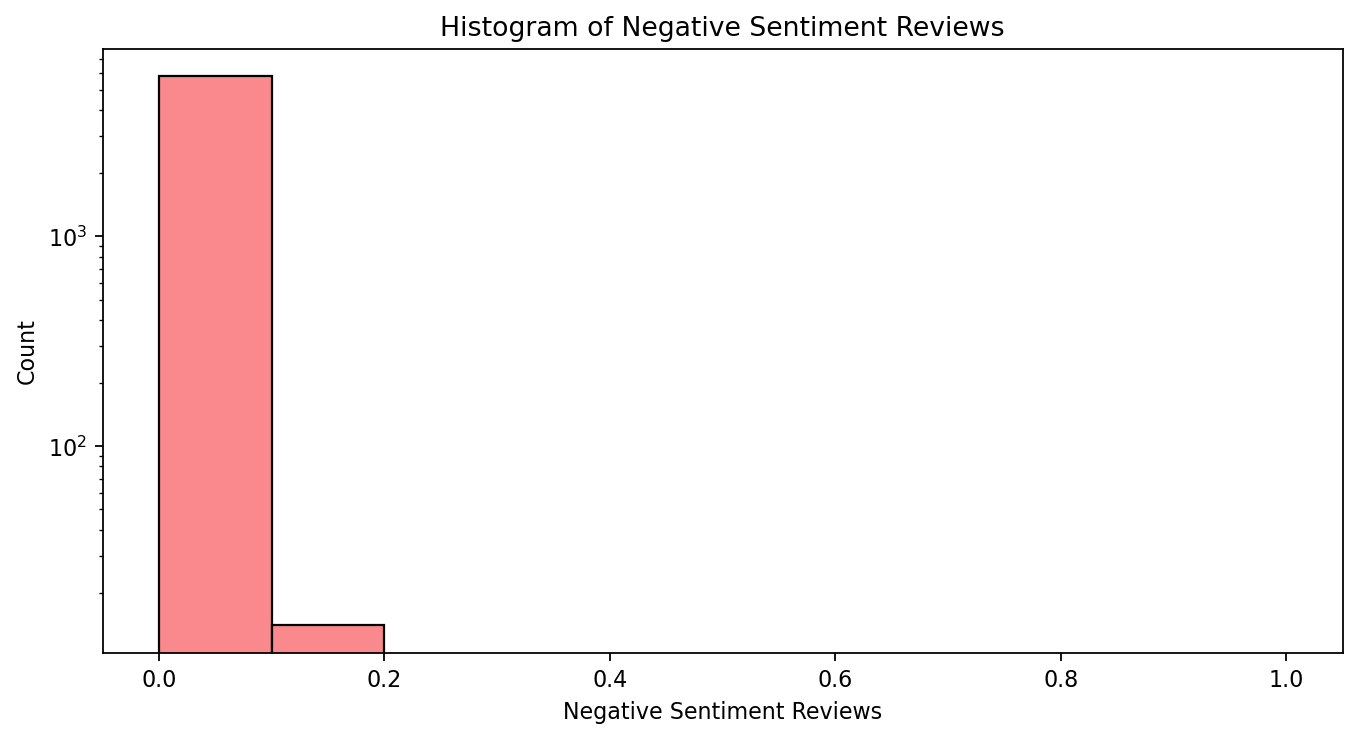

In [332]:
plt.figure(figsize=(10, 5), dpi = 160)

plt.hist(x = X.comments_sentiment_neg, color = '#fa898d', edgecolor = 'black', log = True, range = (0, 1))

plt.xlabel('Negative Sentiment Reviews')
plt.ylabel('Count')
plt.title('Histogram of Negative Sentiment Reviews')

plt.show()


#bins = 16, range = (0, 3000), log = True,

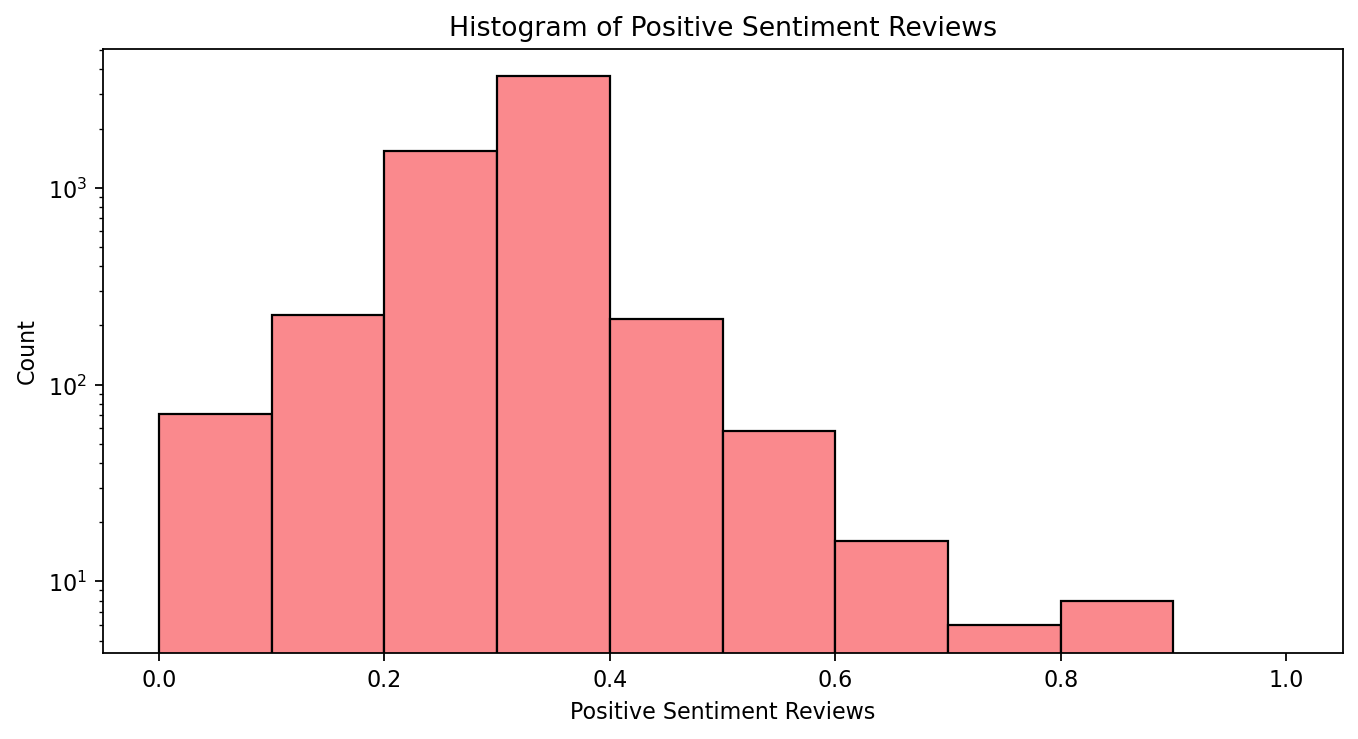

In [321]:
plt.figure(figsize=(10, 5), dpi = 160)

plt.hist(x = X.comments_sentiment_pos, color = '#fa898d', edgecolor = 'black', log = True, range = (0, 1))

plt.xlabel('Positive Sentiment Reviews')
plt.ylabel('Count')
plt.title('Histogram of Positive Sentiment Reviews')

plt.show()


#bins = 16, range = (0, 3000), log = True,

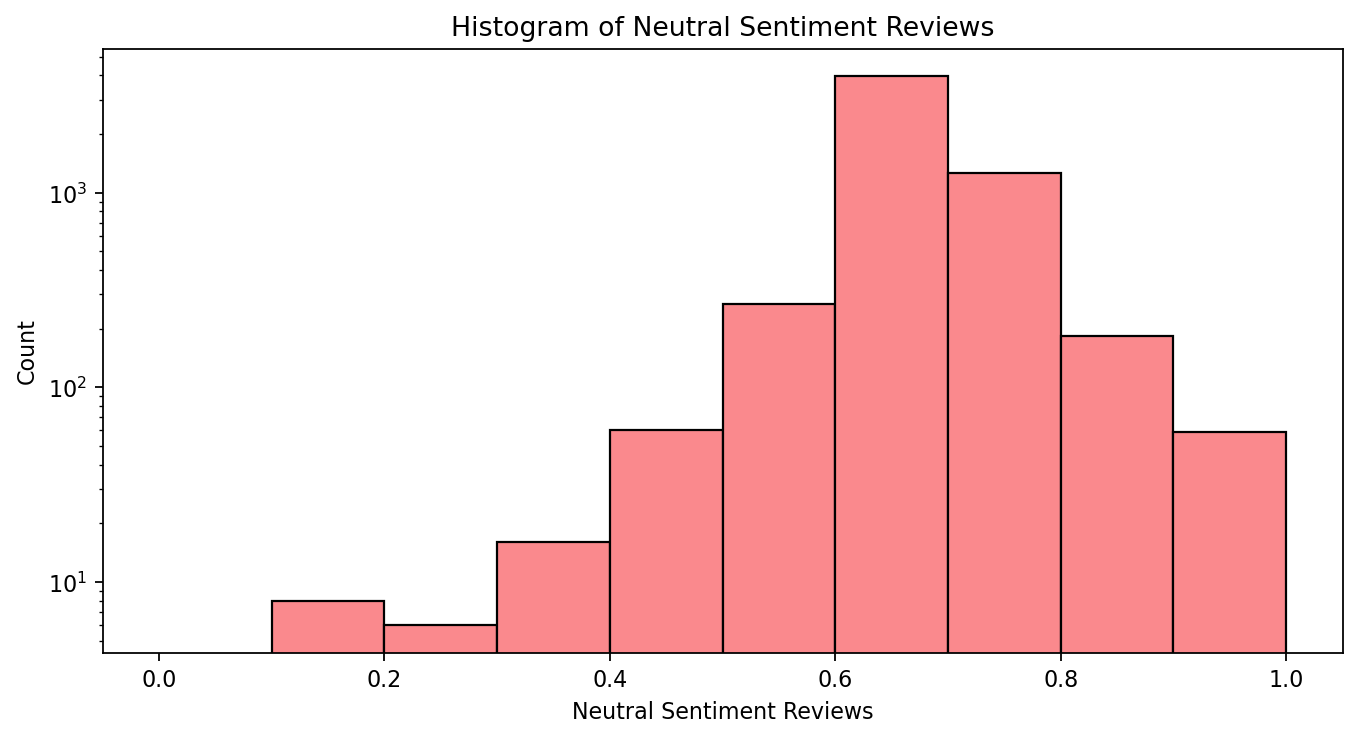

In [322]:
plt.figure(figsize=(10, 5), dpi = 160)

plt.hist(x = X.comments_sentiment_neu, color = '#fa898d', edgecolor = 'black', log = True, range = (0, 1))

plt.xlabel('Neutral Sentiment Reviews')
plt.ylabel('Count')
plt.title('Histogram of Neutral Sentiment Reviews')

plt.show()


#bins = 16, range = (0, 3000), log = True,

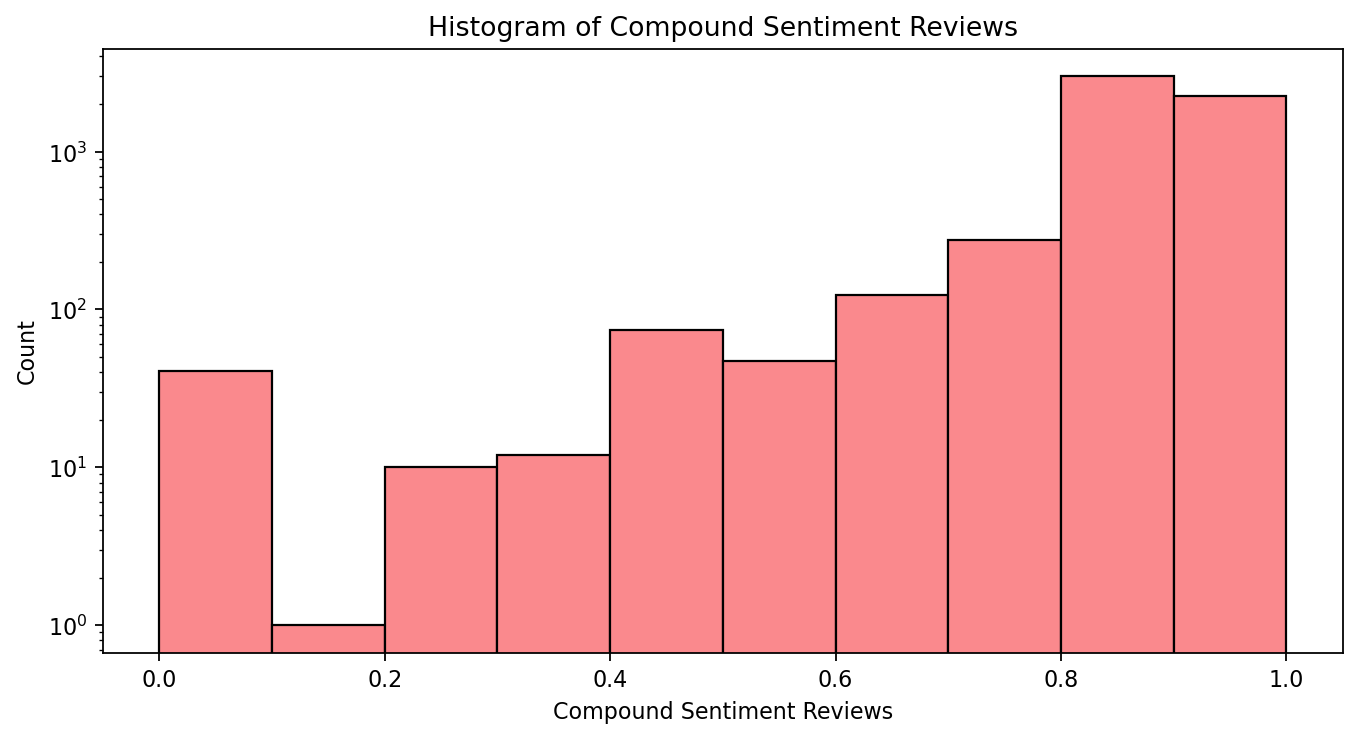

In [323]:
plt.figure(figsize=(10, 5), dpi = 160)

plt.hist(x = X.comments_sentiment_com, color = '#fa898d', edgecolor = 'black', log = True, range = (0, 1))

plt.xlabel('Compound Sentiment Reviews')
plt.ylabel('Count')
plt.title('Histogram of Compound Sentiment Reviews')

plt.show()


#bins = 16, range = (0, 3000), log = True,

In [336]:
listings3.square_feet.head()

0    3600.000000
1    1309.596026
2    1309.596026
3    1309.596026
4    1309.596026
Name: square_feet, dtype: float64

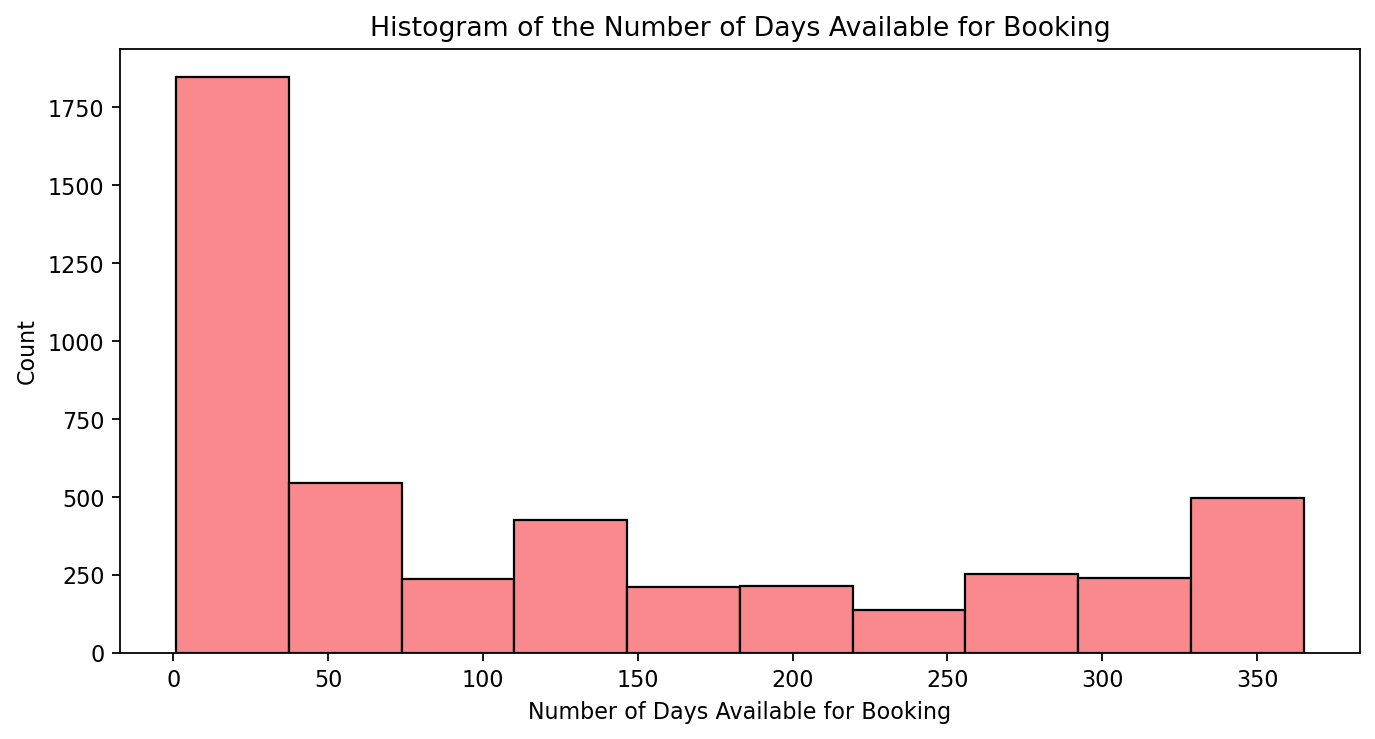

In [359]:
plt.figure(figsize=(10, 5), dpi = 160)

plt.hist(x = days_sold_per_listing.available, color = '#fa898d', edgecolor = 'black')

plt.xlabel('Number of Days Available for Booking')
plt.ylabel('Count')
plt.title('Histogram of the Number of Days Available for Booking')

plt.show()


#bins = 16, range = (0, 3000), log = True,

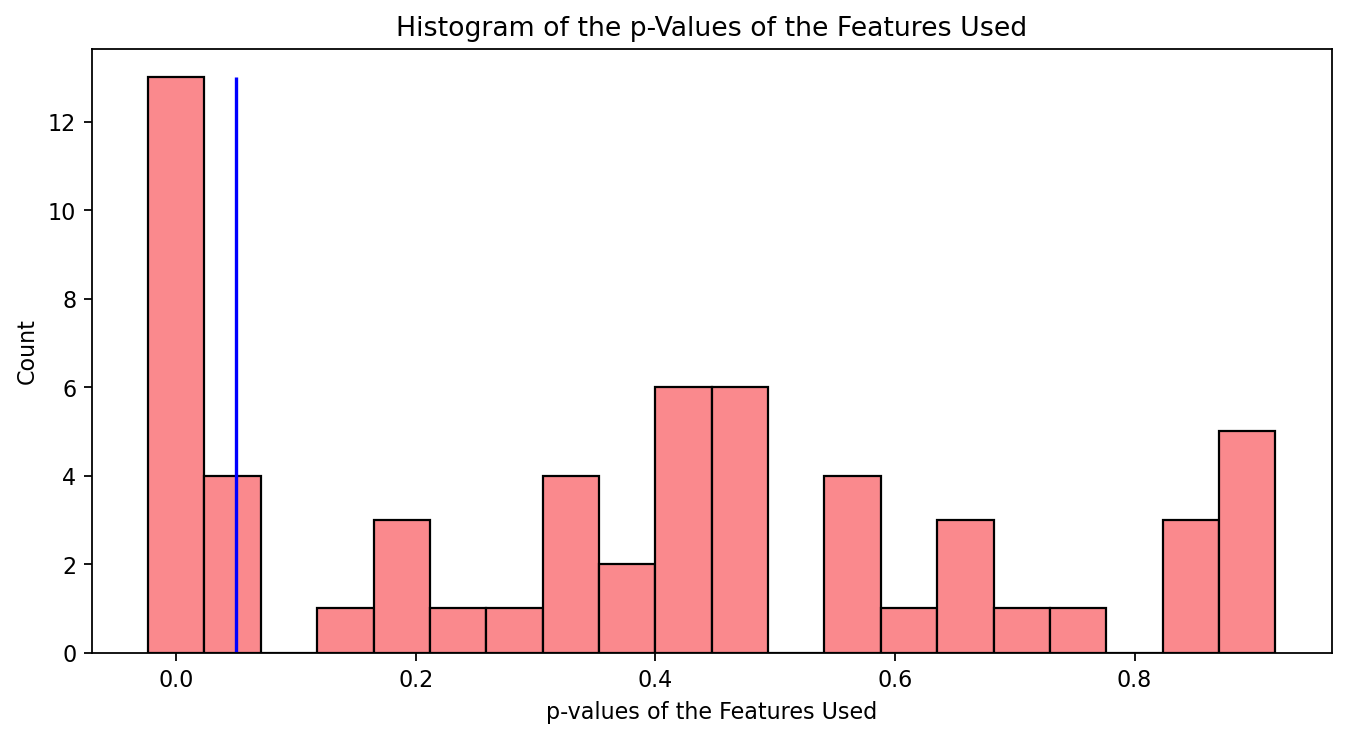

In [396]:
plt.figure(figsize=(10, 5), dpi = 160)

plt.hist(x = est2.pvalues, color = '#fa898d', edgecolor = 'black', bins = 20, align = 'left')

plt.vlines(x = 0.05, ymin = 0, ymax = 13,
           colors = 'blue', label = 'alpha')

plt.xlabel('p-values of the Features Used')
plt.ylabel('Count')
plt.title('Histogram of the p-Values of the Features Used')


plt.show()


#bins = 16, range = (0, 3000), log = True,

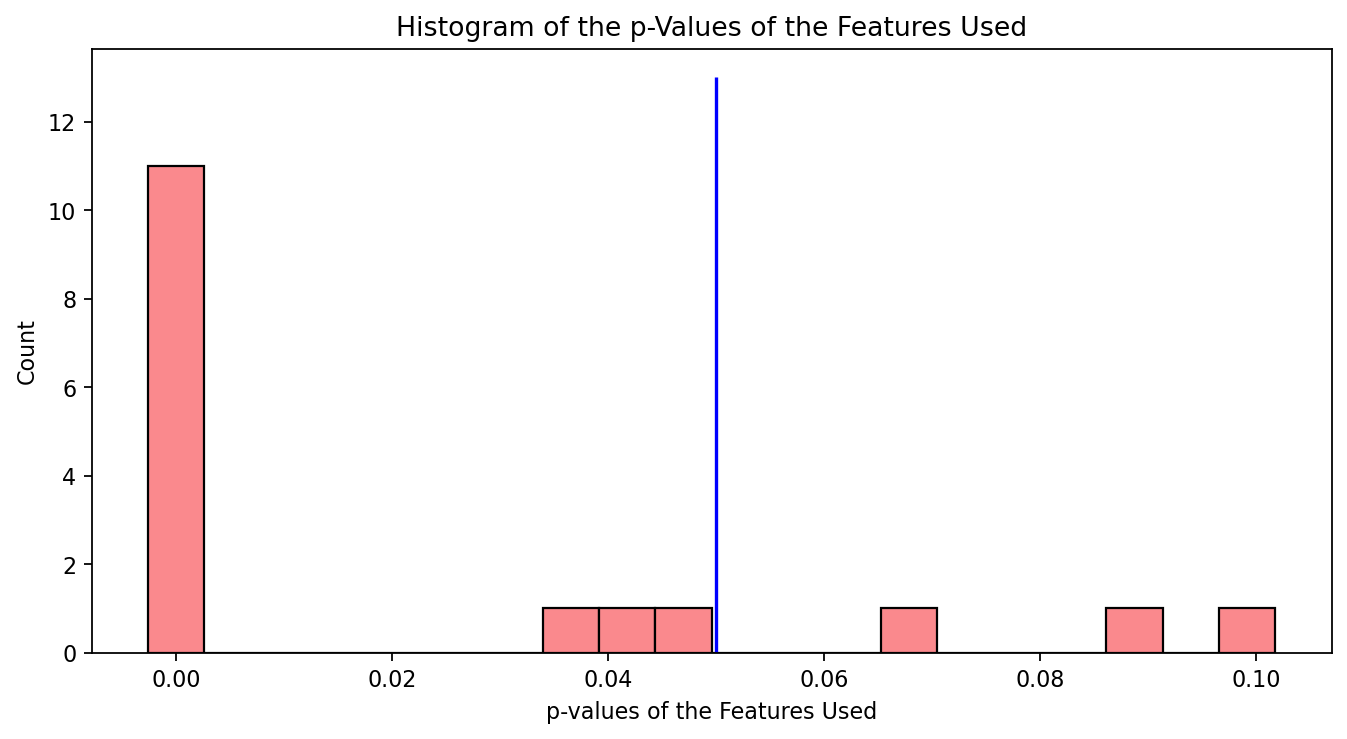

In [407]:
plt.figure(figsize=(10, 5), dpi = 160)

plt.hist(x = est2.pvalues, color = '#fa898d', edgecolor = 'black', bins = 20, align = 'left')

plt.vlines(x = 0.05, ymin = 0, ymax = 13,
           colors = 'blue', label = 'alpha')

plt.xlabel('p-values of the Features Used')
plt.ylabel('Count')
plt.title('Histogram of the p-Values of the Features Used')


plt.show()

In [31]:
cols3 = '''


host_acceptance_rate
host_is_superhost
accommodates
bathrooms
bedrooms
availability_365
require_guest_profile_picture
calculated_host_listings_count
host_verification_reviews
host_verification_google
cancellation_policy_numeric
available



'''.strip().split('\n')

X3 = listings3.loc[:, cols3]
X3_ = sm.add_constant(X3)
est = sm.OLS(y, X3_)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     338.8
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:35:10   Log-Likelihood:                -41741.
No. Observations:                5835   AIC:                         8.351e+04
Df Residuals:                    5822   BIC:                         8.359e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [411]:
est2.fittedvalues

0        433.563503
1        -24.161173
2        394.557976
3        394.557976
4        466.731002
5        297.909777
6        194.291986
7         87.037363
8        241.273942
9         17.424151
10       227.228447
11        21.025957
12        47.805455
13        47.478489
14       138.145502
15       199.441705
16        42.362537
17       206.402913
18       551.010469
19        59.959027
20       208.106313
21       286.721191
22       177.058147
23       141.438009
24       691.791804
25       613.414598
26       152.627557
27        41.708605
28       206.402913
29        40.709965
30       135.208409
31       158.435188
32       297.909777
33       196.754244
34       125.177979
35       194.888392
36       297.909777
37       881.114725
38       902.592738
39       492.465837
40      1156.584733
41       234.360556
42       342.664119
43      1077.020375
44        64.813961
45      1053.897343
46       597.953559
47        83.668064
48      1559.959846
49       590.359569


In [412]:
len(y)

5835

In [413]:
len(est2.fittedvalues)

5835

In [414]:
list(zip(y, est2.fittedvalues))

[(300.0, 433.56350344218214),
 (99.0, -24.161172901553602),
 (100.0, 394.5579762033168),
 (100.0, 394.5579762033168),
 (599.0, 466.73100196653064),
 (100.0, 297.909776932957),
 (54.0, 194.2919857356967),
 (40.0, 87.03736301100022),
 (130.0, 241.2739424720189),
 (44.0, 17.42415092952552),
 (99.0, 227.2284465870975),
 (50.0, 21.025957153365567),
 (49.0, 47.80545494206457),
 (50.0, 47.4784886250705),
 (55.0, 138.14550189994827),
 (180.0, 199.44170522835282),
 (36.0, 42.36253715683625),
 (125.0, 206.40291260043847),
 (59.0, 551.0104686954204),
 (49.0, 59.959026711366434),
 (40.0, 208.1063126286949),
 (150.0, 286.7211914985571),
 (175.0, 177.0581465642234),
 (50.0, 141.438009449084),
 (120.0, 691.7918042835652),
 (450.0, 613.4145982357093),
 (49.0, 152.62755720845934),
 (36.0, 41.708604522848155),
 (75.0, 206.40291260043847),
 (50.0, 40.709965232434264),
 (70.0, 135.20840865708874),
 (36.0, 158.43518833734203),
 (110.0, 297.909776932957),
 (200.0, 196.754244035798),
 (34.0, 125.177979418862

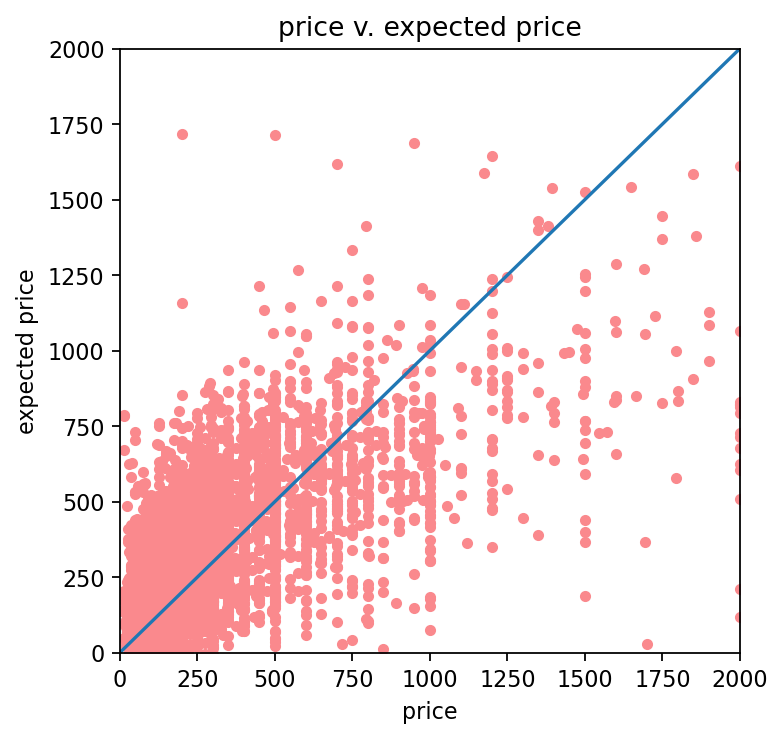

In [30]:
fig, ax = plt.subplots(figsize=(5, 5), dpi = 160)

ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)

ax.scatter(y, est2.fittedvalues, c = '#fa898d', s = 16.0)
ax.plot([0, 2000], [0, 2000])

plt.xlabel('price')
plt.ylabel('expected price')
plt.title('price v. expected price')


plt.show()